# MODELISATION

Pour répondre à notre problématique, nous implémentons deux modèles de machine learning : Random Forest et XGBoost.

Enfin, nous allons utiliser des modèles de machine learning pour prédire le genre d'une musique grâce aux variables dont nous disposons. Nous utilisons d'abord un modèle de type Random Forest, puis un modèle de type XGBoost, pour finalement comparer les deux.

Nous avons réalisé cette partie à partir des articles de Ilyes TALBI, Samir JEETO et Valentin DORE.

### Importation

In [91]:
#Pour la récupération des données
import pandas as pd

#Pour la visualisation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Pour la modélisation
from scipy.stats import randint, uniform
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, zero_one_loss, classification_report
from sklearn.preprocessing import normalize, StandardScaler
from pprint import pprint

In [56]:
file_path = "/tlaflotte/genre_detector/data_tracks_cleaned.csv"

df = pd.read_csv("https://minio.lab.sspcloud.fr" + file_path)

# I - Random Forest

Tout d'abord, nous séparons la variable à prédire (le genre) des autres variables (les features). Ensuite, nous séparons ces ensembles en deux parties, l'une pour entraîner le modèle et l'autre pour tester le modèle. Comme notre base de données est ordonnée par genre, nous indiquons qu'il faut bisséquer aléatoirement cette base de données avec l'argument shuffle=True.

Nous pourrions enlever des variables puisque notre étape de visualisation a mis en évidence de fortes corrélations entre certaines d'entre elles. Cela ferait gagner du temps, pour un petit peu moins de précision. Nous avons choisi de garder toutes nos variables car le temps de calcul n'est pas très long.

In [53]:
features = df.copy()

# isolation of the feature to predict
genres = np.array(features['playlist_genre'])
features = features.drop(['playlist_genre', 'playlist_subgenre_encoded'], axis = 1)
feature_list = list(features.columns)
features = np.array(features)

# separation in training and testing sets
train_features, test_features, train_genres, test_genres = train_test_split(features, genres, test_size = 0.25, random_state = 0, shuffle = True)
print('Training Features Shape:', train_features.shape)
print('Training Genres Shape:', train_genres.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Genres Shape:', test_genres.shape)

# reshaping
sc = StandardScaler()
train_features = sc.fit_transform(train_features)
test_features = sc.transform(test_features)

Training Features Shape: (24624, 13)
Training Genres Shape: (24624,)
Testing Features Shape: (8209, 13)
Testing Genres Shape: (8209,)


## Tuning des hyper-paramètres

Maintentant, nous allons procéder au tuning des hyper-paramètres.

In [40]:
rf = RandomForestClassifier(random_state = 0)

print('Parameters currently in use:\n')
print(rf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


Il y a bien trop d'hyper-paramètres sur lesquels nous pouvons jouer. Nous choisissons de jouer sur le nombre d'arbres, la profondeur maximale des arbres, et le nombre minimal d'échantillons par noeuds.

Nous n'avons pas indiqué des poids pour chaque genre, car la base de données est relativement équilibrée. Pour améliorer le modèle, nous pourrions mettre des poids à chaque genre pour avoir une base de données parfaitement équilibrée.

Voici, les valeurs pour lesquelles nous allons tester les performances du modèle.

In [69]:
n_estimators = [1000, 2000, 4000]
max_depth = [20,None]
min_samples_split = [2, 4]

# creation of the grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
              }

print(random_grid)

{'n_estimators': [1000, 2000, 4000], 'max_depth': [20, None], 'min_samples_split': [2, 4]}


Nous faisons donc un random search avec ces différents hyper-paramètres et nous classons les différentes combinaisons d'hyper-paramètres par précision.

Nous voyons que les résultats sont meilleurs lorsqu'on fixe `min_samples_split` à 4 et `min_samples_leaf` à 1. De plus, nous observons de meilleurs résultats pour 2000 et 4000 arbres.

In [70]:
# creation of the model
rf = RandomForestClassifier(random_state = 0, max_features = 'sqrt', bootstrap = True)

# random search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 12, cv = 3, verbose=2, random_state=0, n_jobs = -1)

# fit
rf_random.fit(train_features, train_genres)

pd_res = pd.concat([pd.DataFrame(rf_random.cv_results_["params"]),pd.DataFrame(rf_random.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(rf_random.best_params_)
print(pd_res.head)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END max_depth=20, min_samples_split=2, n_estimators=1000; total time=  53.4s
[CV] END max_depth=20, min_samples_split=2, n_estimators=1000; total time=  53.5s
[CV] END max_depth=20, min_samples_split=2, n_estimators=1000; total time=  55.1s
[CV] END max_depth=20, min_samples_split=2, n_estimators=2000; total time= 1.7min
[CV] END max_depth=20, min_samples_split=2, n_estimators=2000; total time= 1.9min
[CV] END max_depth=20, min_samples_split=2, n_estimators=2000; total time= 1.8min


/opt/conda/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=20, min_samples_split=4, n_estimators=1000; total time=  52.0s
[CV] END max_depth=20, min_samples_split=4, n_estimators=1000; total time=  45.3s
[CV] END max_depth=20, min_samples_split=4, n_estimators=1000; total time=  48.8s
[CV] END max_depth=20, min_samples_split=2, n_estimators=4000; total time= 3.4min
[CV] END max_depth=20, min_samples_split=2, n_estimators=4000; total time= 3.5min
[CV] END max_depth=20, min_samples_split=2, n_estimators=4000; total time= 3.3min
[CV] END max_depth=20, min_samples_split=4, n_estimators=2000; total time= 1.6min
[CV] END max_depth=20, min_samples_split=4, n_estimators=2000; total time= 1.6min
[CV] END max_depth=20, min_samples_split=4, n_estimators=2000; total time= 1.6min
[CV] END max_depth=None, min_samples_split=2, n_estimators=1000; total time=  52.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=1000; total time=  49.8s
[CV] END max_depth=None, min_samples_split=2, n_estimators=1000; total time=  52.7s
[CV] END m

Après ces premiers résultats, nous fixons donc `min_samples_split` à 2, et nous continuons notre sélection d'hyper-paramètres (nombre d'arbres et profondeur maximale d'un arbre) grâce à un grid search. Il semble que 4000 arbres et une profondeur maximale de 20 soient les meilleures valeurs, mais nous voulons vérifier avec ce grid search.

De même, nous classons les résultats obtenus par précision.

Compte tenu des résultats, nous fixons le nombre d'arbres à 4000, et nous choisissons de garder une profondeur maximale à 20 car il est risqué de fixer une trop grande profondeur (possible overfitting).

In [ ]:
param_grid = {
    'max_depth': [20, None],
    'min_samples_split': [2],
    'n_estimators': [2000, 4000]
}
print(param_grid)

# création du modèle
rf = RandomForestClassifier(random_state = 0, bootstrap=True)

# grid search
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(train_features, train_genres)

pd_res = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(pd_res)

{'max_depth': [20, None],
 'min_samples_split': [2],
 'n_estimators': [2000, 4000]}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END max_depth=20, min_samples_split=2, n_estimators=2000; total time= 1.5min
[CV] END max_depth=20, min_samples_split=2, n_estimators=2000; total time= 1.5min
[CV] END max_depth=20, min_samples_split=2, n_estimators=2000; total time= 1.6min
[CV] END max_depth=20, min_samples_split=2, n_estimators=4000; total time= 3.0min


/opt/conda/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=20, min_samples_split=2, n_estimators=4000; total time= 3.1min
[CV] END max_depth=None, min_samples_split=2, n_estimators=2000; total time= 1.6min
[CV] END max_depth=None, min_samples_split=2, n_estimators=2000; total time= 1.5min
[CV] END max_depth=20, min_samples_split=2, n_estimators=4000; total time= 3.2min
[CV] END max_depth=None, min_samples_split=2, n_estimators=2000; total time= 1.7min
[CV] END max_depth=None, min_samples_split=2, n_estimators=4000; total time= 3.4min
[CV] END max_depth=None, min_samples_split=2, n_estimators=4000; total time= 3.5min
[CV] END max_depth=None, min_samples_split=2, n_estimators=4000; total time= 3.6min
   max_depth  min_samples_split  n_estimators  Accuracy
3        NaN                  2          4000  0.554012
1       20.0                  2          4000  0.553525
0       20.0                  2          2000  0.553241
2        NaN                  2          2000  0.553241


Nous avons donc fini la partie du tuning des hyper-paramètres, et nous pouvons alors lancer le modèle.

## Lancement du modèle

In [72]:
# creation of the model
rf = RandomForestClassifier(n_estimators=4000, max_features='sqrt', max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, criterion='gini' ,random_state=0)

# fit
rf.fit(train_features, train_genres)

# prédictions
predictions = rf.predict(test_features)

# Zero_one_loss error
errors = zero_one_loss(test_genres, predictions, normalize=True)
print('zero_one_loss error normalized:', errors)

# Accuracy Score
accuracy_test = accuracy_score(test_genres, predictions)
print('accuracy_score on test dataset :', accuracy_test)

print(classification_report(predictions, test_genres))

zero_one_loss error normalized: 0.43074674138141067
accuracy_score on test dataset : 0.5692532586185893
              precision    recall  f1-score   support

         edm       0.70      0.68      0.69      1572
       latin       0.40      0.52      0.45      1004
         pop       0.36      0.38      0.37      1287
         r&b       0.49      0.50      0.49      1310
         rap       0.67      0.60      0.63      1614
        rock       0.78      0.69      0.73      1422

    accuracy                           0.57      8209
   macro avg       0.57      0.56      0.56      8209
weighted avg       0.58      0.57      0.57      8209



Nous obtenons une précision de 56% ce qui n'est pas très satisfaisant.

Nous traçons la matrice de confusion pour visualiser les différentes erreurs.

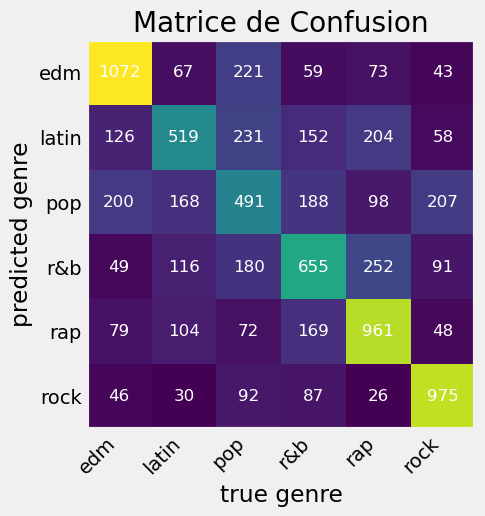

In [73]:
#Confusion matrix

mat = confusion_matrix(test_genres, predictions)
plt.imshow(mat, cmap='viridis', interpolation='nearest')
#plt.colorbar(label='Valeurs')
plt.title('Matrice de Confusion')
num_rows, num_cols = mat.shape
for i in range(num_rows):
    for j in range(num_cols):
        plt.text(j, i, str(mat[i, j]), ha='center', va='center', color='w', fontsize=12)
plt.grid(False)
genres_list = ['edm','latin','pop','r&b','rap','rock']
plt.xticks(np.arange(num_cols), genres_list, rotation=45, ha='right')
plt.yticks(np.arange(num_rows), genres_list)
plt.xlabel('true genre')
plt.ylabel('predicted genre')
plt.show()

Grâce à la matrice des confusions, nous pouvons voir par exemple que les musiques rock sont bien classées, sauf quelques unes qui sont évaluées comme des musiques pop !

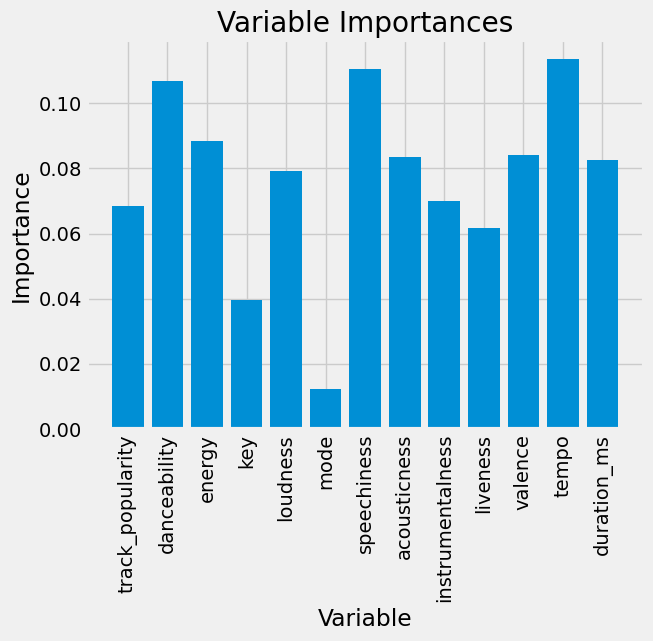

In [75]:
#Feature importances
plt.style.use('fivethirtyeight')

importances = list(rf.feature_importances_)

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')
plt.show()

Enfin, nous traçons ici l'importance de chaque variable. Nous observons que key et mode ne sont pas très utiles à la prédiction. Nous pouvions nous y attendre puisque ce sont des variables qui varient relativement peu, et qui sont décorrélées de chaque genre.

Ainsi, notre modélisation Random Forest permet de prédire un genre musical avec une précision de 56%, ce qui est satisfaisant, mais en réalité elle identifie mal les genres pop et r&b qui sont très représentés dans le monde de la musique, tandis qu'elle identifie bien le genre edm, qui n'est pas le genre le plus écouté de nos jours.

# II - XGBoost

Nous utilisons maintenant le modèle XGBoost.

## Encodage de Genre

 Ici, nous attribuons à chaque genre une valeur numérique (entre 0 et 8) pour pouvoir utiliser ce modèle.

In [94]:
features = df.copy()

def genre_to_num(genre):
    if genre == 'edm':
        return 0
    if genre == 'latin':
        return 1
    if genre == 'pop':
        return 2
    if genre == 'r&b':
        return 3
    if genre == 'rap':
        return 4
    if genre == 'rock':
        return 5

features['playlist_genre'] = features['playlist_genre'].apply(genre_to_num)

On peut maintenant séparer notre base de données entre train et test

In [95]:
# isolation of the feature to predict
genres = np.array(features['playlist_genre'])
features = features.drop(['playlist_genre', 'playlist_subgenre_encoded'], axis = 1)
feature_list = list(features.columns)
features = np.array(features)

# separation in training and testing sets
train_features, test_features, train_genres, test_genres = train_test_split(features, genres, test_size = 0.25, random_state = 0, shuffle = True)
print('Training Features Shape:', train_features.shape)
print('Training Genres Shape:', train_genres.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Genres Shape:', test_genres.shape)

# reshaping
sc = StandardScaler()
train_features = sc.fit_transform(train_features)
test_features = sc.transform(test_features)

Training Features Shape: (24624, 13)
Training Genres Shape: (24624,)
Testing Features Shape: (8209, 13)
Testing Genres Shape: (8209,)


## Tuning des hyper-paramètres

Pour commencer la phase de tuning des hyper-paramètres, nous regardons sur quels paramètres nous pouvons jouer.

In [96]:
clf = XGBClassifier(objective= 'multi:softprob', random_state = 42)
print('Parameters currently in use:\n')
pprint(clf.get_params())

Parameters currently in use:

{'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'objective': 'multi:softprob',
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}


Il y en une multitude : nous sélectionnons seulement max_depth (la profondeur maximale d'un arbre) et n_estimators (le nombre d'arbres). Voici les valeurs pour lesquelles nous allons tester la précision du modèle.

In [97]:
random_grid = {
    "gamma" : [0],
    "learning_rate" : [0.1],
    "max_depth" : [20, None],
    "n_estimators" : [100, 200, 300, 400, 500], 
    "subsample" : [0.8]}

pprint(random_grid)

{'gamma': [0],
 'learning_rate': [0.1],
 'max_depth': [20, None],
 'n_estimators': [100, 200, 300, 400, 500],
 'subsample': [0.8]}


Nous faisons donc un random search avec ces différentes valeurs, et nous affichons la précision obtenue pour chacune des combinaisons possibles.

In [102]:
# Model creation
clf = XGBClassifier(objective='multi:softprob', random_state=42)

# Random search
clf_random = RandomizedSearchCV(estimator=clf, param_distributions=random_grid, n_iter=10, cv=3, verbose=2, random_state=0, n_jobs=-1)

# Fit the model
clf_random.fit(train_features, train_genres)

pd_res = pd.concat([pd.DataFrame(clf_random.cv_results_["params"]), pd.DataFrame(clf_random.cv_results_["mean_test_score"], columns=["Accuracy"])], axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(pd_res)


AttributeError: 'super' object has no attribute '__sklearn_tags__'